In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import autocorr

from scipy.ndimage.filters import gaussian_filter

from astropy.stats import LombScargle

In [39]:
data = np.loadtxt('230763211.dat.ts')
t = np.array(data[:, 0]*0.0864)
y = np.array(data[:, 1]*1e3)

In [40]:
df = 0.01 / (np.max(t) - np.min(t))
freq = np.arange(10.0, 0.5 / np.median(np.diff(t)), df)
len(freq)

172681

In [41]:
model = LombScargle(t, y)
power = model.power(freq)

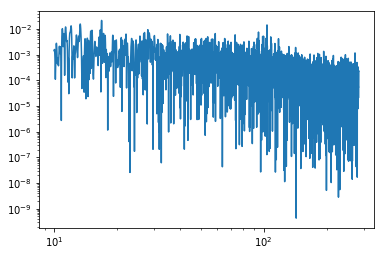

In [42]:
plt.loglog(freq, power)

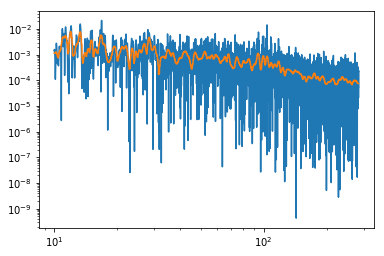

In [43]:
def estimate_background(x, y, log_width=0.005):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

bkg = estimate_background(freq, power)
plt.loglog(freq, power)
plt.plot(freq, bkg)

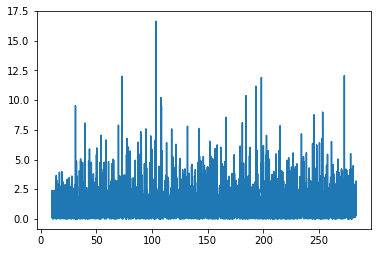

In [44]:
plt.plot(freq, power / bkg)

In [45]:
df = freq[1] - freq[0]
smoothed_ps = gaussian_filter(power / bkg, 5 / df)

# And the autocorrelation function of a lightly smoothed power spectrum
acor_func = autocorr.function_1d(gaussian_filter(power / bkg, 0.5 / df))
lags = df*np.arange(len(acor_func))
acor_func = acor_func[lags < 30]
lags = lags[lags < 30]

# Find the peaks
def find_peaks(z):
    peak_inds = (z[1:-1] > z[:-2]) * (z[1:-1] > z[2:])
    peak_inds = np.arange(1, len(z)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(z[peak_inds])][::-1]
    return peak_inds

peak_freqs = freq[find_peaks(smoothed_ps)]
nu_max = peak_freqs[peak_freqs > 5][0]

# Expected delta_nu: Stello et al (2009)
dnu_expected = 0.263 * nu_max ** 0.772
peak_lags = lags[find_peaks(acor_func)]
delta_nu = peak_lags[np.argmin(np.abs(peak_lags - dnu_expected))]
print("nu_max = {0}, delta_nu = {1}".format(nu_max, delta_nu))

nu_max = 105.09194928492161, delta_nu = 9.460775505433745


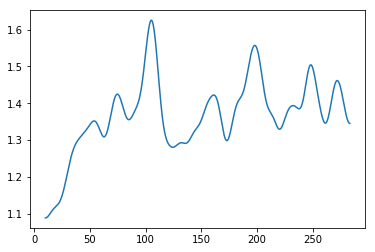

In [46]:
plt.plot(freq,smoothed_ps)